In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

from osgeo import gdal    ## used to read images in memory

import tensorflow as tf

################################################################
## Storing and timing Models
import pickle
from joblib import dump,load
import time

################################################################
# Custom functions from lib.py
from lib import dataExtract, dataStack, indicesFromDataStack, \
                stochasticPCAFromDataStack, stochasticICAFromDataStack, \
                stackToImage, featuresCompute, \
                vectorStackToImage, stackToImage2, preProcessImgs2

################################################################
import warnings
warnings.filterwarnings("ignore")

################################################################

plotBool = 0


#### Display Data

In [2]:
if plotBool == 1:
    '''
    Extract Data
    '''
    colNames = ['coastal','blue','green','yellow','red','red edge','near IR1', 'near IR2','AGL','CLS']
    rawDataTrain = dataExtract(foldername='train')
    numImages = len(rawDataTrain)

    imgIdx = 1   ## index of image to plot

    fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(12,10))
    img = ax[0][0].imshow(rawDataTrain['MSI'][imgIdx][0].astype(np.uint8), cmap='Blues'); ax[0][0].set_title('Coastal: 400-450 nm'); fig.colorbar(img, ax=ax[0][0], fraction=0.05)
    img = ax[0][1].imshow(rawDataTrain['MSI'][imgIdx][1].astype(np.uint8), cmap='Blues'); ax[0][1].set_title('Blue: 450-510 nm'); fig.colorbar(img, ax=ax[0][1], fraction=0.05)
    img = ax[0][2].imshow(rawDataTrain['MSI'][imgIdx][2].astype(np.uint8), cmap='Greens'); ax[0][2].set_title('Green: 510-580 nm'); fig.colorbar(img, ax=ax[0][2], fraction=0.05)
    img = ax[1][0].imshow(rawDataTrain['MSI'][imgIdx][3].astype(np.uint8), cmap='YlOrRd_r'); ax[1][0].set_title('Yellow: 585-625 nm'); fig.colorbar(img, ax=ax[1][0], fraction=0.05)
    img = ax[1][1].imshow(rawDataTrain['MSI'][imgIdx][4].astype(np.uint8), cmap='Reds'); ax[1][1].set_title('Red: 630-690 nm'); fig.colorbar(img, ax=ax[1][1], fraction=0.05)
    img = ax[1][2].imshow(rawDataTrain['MSI'][imgIdx][5].astype(np.uint8), cmap='Reds'); ax[1][2].set_title('Red Edge: 705-745 nm'); fig.colorbar(img, ax=ax[1][2], fraction=0.05)
    img = ax[2][0].imshow(rawDataTrain['MSI'][imgIdx][6].astype(np.uint8), cmap='Oranges'); ax[2][0].set_title('near IR1: 770-895 nm'); fig.colorbar(img, ax=ax[2][0], fraction=0.05)
    img = ax[2][1].imshow(rawDataTrain['MSI'][imgIdx][7].astype(np.uint8), cmap='Oranges'); ax[2][1].set_title('near IR2: 860-1040 nm'); fig.colorbar(img, ax=ax[2][1], fraction=0.05)
    img = ax[2][2].imshow(rawDataTrain['AGL'][imgIdx].astype(np.uint8), cmap='gray'); ax[2][2].set_title('AGL'); fig.colorbar(img, ax=ax[2][2], fraction=0.05)

    fig.tight_layout()
    plt.savefig('./plots/rawData.svg')

    '''
    Compute Features
    '''
    dataTrain = dataStack(rawDataTrain)
    ## Compute features
    dataTrain = pd.DataFrame( np.array(dataTrain) , columns=colNames )
    # dataTrain = featuresCompute(dataTrain, numPCA=3, numICA=3 )
    print(f'Feature Names:\n{dataTrain.columns}')

    '''
    Remove Irrelevant Classes
    '''
    groundTruthCLS = np.array(dataTrain['CLS'])
    groundTruthCLS[np.where(groundTruthCLS==9)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==17)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==65)[0]] = 2
    groundTruthCLS[np.where(groundTruthCLS==2)[0]] = 0

    trainGroundTruth = vectorStackToImage(pd.DataFrame(groundTruthCLS,columns=['CLS']),colNames=['CLS'])
    del groundTruthCLS

    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    img = ax[0].imshow((trainGroundTruth['CLS'][imgIdx]==6).astype(np.uint8), cmap='gray'); ax[0].set_title('Class Labels: \nBuildings (6)'); fig.colorbar(img, ax=ax[0], fraction=0.05)
    img = ax[1].imshow((trainGroundTruth['CLS'][imgIdx]==5).astype(np.uint8), cmap='Greens'); ax[1].set_title('Class Labels: \nTrees (5)'); fig.colorbar(img, ax=ax[1], fraction=0.05)
    img = ax[2].imshow((trainGroundTruth['CLS'][imgIdx]==0).astype(np.uint8), cmap='YlOrRd_r'); ax[2].set_title('Class Labels: \nOther (0)'); fig.colorbar(img, ax=ax[2], fraction=0.05)
    fig.tight_layout()
    plt.savefig('./plots/rawDataCLSReduced.svg')

    plt.show()


## Pre-Process Data
Labels: 6: Building, 3: Tree, 0: Other

In [3]:
XTrain,YTrain,cols = preProcessImgs2(imgFolder='train',annotationFolder='trainImgCLS')

Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'CLS'],
      dtype='object')


In [4]:
XValid,YValid,cols = preProcessImgs2(imgFolder='test2_assignment_2_sim',annotationFolder='validImgCLS')

Feature Names:
Index(['coastal', 'blue', 'green', 'yellow', 'red', 'red edge', 'near IR1',
       'near IR2', 'AGL', 'CLS'],
      dtype='object')


In [5]:
# XTest,YTest,cols = preProcessImgs2(imgFolder='test1',annotationFolder='testImgCLS')

In [6]:
def subimagesDataset(dataset,subimgSize=(256,256)):
    def subimages(img,subimgSize):
        imgList = []
        for i in range(0,img.shape[0],subimgSize[0]):
            for j in range(0,img.shape[1],subimgSize[1]):
                imgList.append(img[0+i:i+subimgSize[0],0+j:j+subimgSize[1]])
        return np.array(imgList).astype(np.float32)
    
    subimagesAll = subimages(dataset[0],subimgSize)   
    for img in dataset[1:]:
        subimagesAll = np.concatenate((subimagesAll,subimages(img,subimgSize)) , axis=0)
    return subimagesAll

In [7]:
XTrain = subimagesDataset(XTrain,subimgSize=(256,256))
YTrain = subimagesDataset(YTrain,subimgSize=(256,256))

print(XTrain.shape)
print(YTrain.shape)

XValid = subimagesDataset(XValid,subimgSize=(256,256))
YValid = subimagesDataset(YValid,subimgSize=(256,256))

print(XValid.shape)
print(YValid.shape)

(496, 256, 256, 9)
(496, 256, 256)
(160, 256, 256, 9)
(160, 256, 256)


# U-NET

### Model: Definition

In [8]:
from tensorflow.keras.layers import Input,Conv2D,BatchNormalization, \
                                    Activation,MaxPool2D,UpSampling2D, \
                                    Concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

def conv_block(inputs,filters,pool=True):
    x = Conv2D(filters,3,padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2,2))(x)
        return x,p
    else:
        return x

def build_unet(shape,num_classes):
    inputs = Input(shape)

    """Encoder"""
    x1,p1 = conv_block(inputs,16,pool=True)
    x2,p2 = conv_block(p1,32,pool=True)
    x3,p3 = conv_block(p2,64,pool=True)
    x4,p4 = conv_block(p3,128,pool=True)
    
    """Bridge"""
    b1 = conv_block(p4,256,pool=False)

    """Decoder"""    
    u1 = UpSampling2D((2,2),interpolation="bilinear")(b1)
    c1 = Concatenate()([u1,x4])
    x5 = conv_block(c1,128,pool=False)

    u2 = UpSampling2D((2,2),interpolation="bilinear")(x5)
    c2 = Concatenate()([u2,x3])
    x6 = conv_block(c2,64,pool=False)
    
    u3 = UpSampling2D((2,2),interpolation="bilinear")(x6)
    c3 = Concatenate()([u3,x2])
    x7 = conv_block(c3,32,pool=False)

    u4 = UpSampling2D((2,2),interpolation="bilinear")(x7)
    c4 = Concatenate()([u4,x1])
    x8 = conv_block(c4,16,pool=False)
    
    """Output"""
    output = Conv2D(num_classes, 1,padding='same',activation="softmax")(x8)
    return Model(inputs,output)

if __name__ == "__main__":
    model = build_unet((256,256,9),3)
    print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 9) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 1312        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### Model: Implementation

In [9]:
H = 256
W = 256
numClasses = 3
numFeatures = len(cols)
batchsize=8
lr = 1e-3
epochs=15
shape = (H,W,numFeatures)

def preprocess(x,y):
    image = tf.convert_to_tensor(x.astype(np.float32), dtype=tf.float32)
    mask = tf.convert_to_tensor(y.astype(np.int32), dtype=tf.int32)
    mask = tf.one_hot(mask,numClasses,dtype=tf.int32)
    image.set_shape([len(x),H,W,numFeatures])
    mask.set_shape([len(x),H,W,numClasses])
    return image,mask

def tf_dataset(x,y,batch=8):
    X0,Y0 = preprocess(x,y)
    dataset = tf.data.Dataset.from_tensor_slices((X0,Y0))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset


In [10]:
train_dataset = tf_dataset(np.nan_to_num(XTrain,nan=0),YTrain,batch=batchsize)
valid_dataset = tf_dataset(np.nan_to_num(XValid,nan=0),YValid,batch=batchsize)

print('Training Batches')
for x,y in train_dataset:
    print(x.shape,y.shape)
print('\nValidation Batches')
for x,y in valid_dataset:
    print(x.shape,y.shape)

Training Batches
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 3)
(8, 256, 256, 9) (8, 256, 256, 

In [11]:
YTrain.shape

(496, 256, 256)

#### Training

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

""" U-Net Model """
model = build_unet(shape,numClasses)
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr))

train_steps = len(XTrain)//batchsize
valid_steps = len(XValid)//batchsize

callbacks = [
    ModelCheckpoint("modelUnet.h5",verbose=1,save_best_model=True),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,verbose=1,min_lr=1e-6),
    EarlyStopping(monitor='val_loss',patience=5,verbose=1)
]

model.fit(train_dataset,
    steps_per_epoch=train_steps,
    validation_data=valid_dataset,
    validation_steps=valid_steps,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
62/62 [==============================] - 25s 290ms/step - loss: 0.2882 - val_loss: 1.1559

Epoch 00001: saving model to modelUnet.h5
Epoch 2/15
62/62 [==============================] - 19s 303ms/step - loss: 0.1630 - val_loss: 0.6569

Epoch 00002: saving model to modelUnet.h5
Epoch 3/15
62/62 [==============================] - 20s 320ms/step - loss: 0.1217 - val_loss: 0.1101

Epoch 00003: saving model to modelUnet.h5
Epoch 4/15
62/62 [==============================] - 21s 334ms/step - loss: 0.0984 - val_loss: 0.0547

Epoch 00004: saving model to modelUnet.h5
Epoch 5/15
62/62 [==============================] - 22s 339ms/step - loss: 0.0875 - val_loss: 0.0661

Epoch 00005: saving model to modelUnet.h5
Epoch 6/15
62/62 [==============================] - 22s 350ms/step - loss: 0.0748 - val_loss: 0.0215

Epoch 00006: saving model to modelUnet.h5
Epoch 7/15
62/62 [==============================] - 22s 351ms/step - loss: 0.0645 - val_loss: 0.0656

Epoch 00007: saving model to model

In [13]:
model = tf.keras.models.load_model('modelUnet.h5')
predictionsSoftmax = model.predict(XValid)
predictions = np.argmax(predictionsSoftmax, axis=-1)

In [62]:
def predictionUNet(predictionsSoftmaxImg):
    predictionImg = np.zeros((predictionsSoftmaxImg[:,:,0].shape) , dtype=np.uint8)
    for i in range(0,256):
        for j in range(0,256):
            if predictionsSoftmaxImg[i,j,0]>0.95:
                predictionImg[i,j] = 0
            else:
                predictionImg[i,j] = 1 + np.argmax(predictionsSoftmaxImg[i,j,1:])
    return predictionImg
   
predictions = np.zeros((predictionsSoftmax.shape[0:-1]),dtype=np.uint8)
for imgIdx in range(len(predictionsSoftmax)):
    predictions[imgIdx] = predictionUNet(predictionsSoftmax[imgIdx])

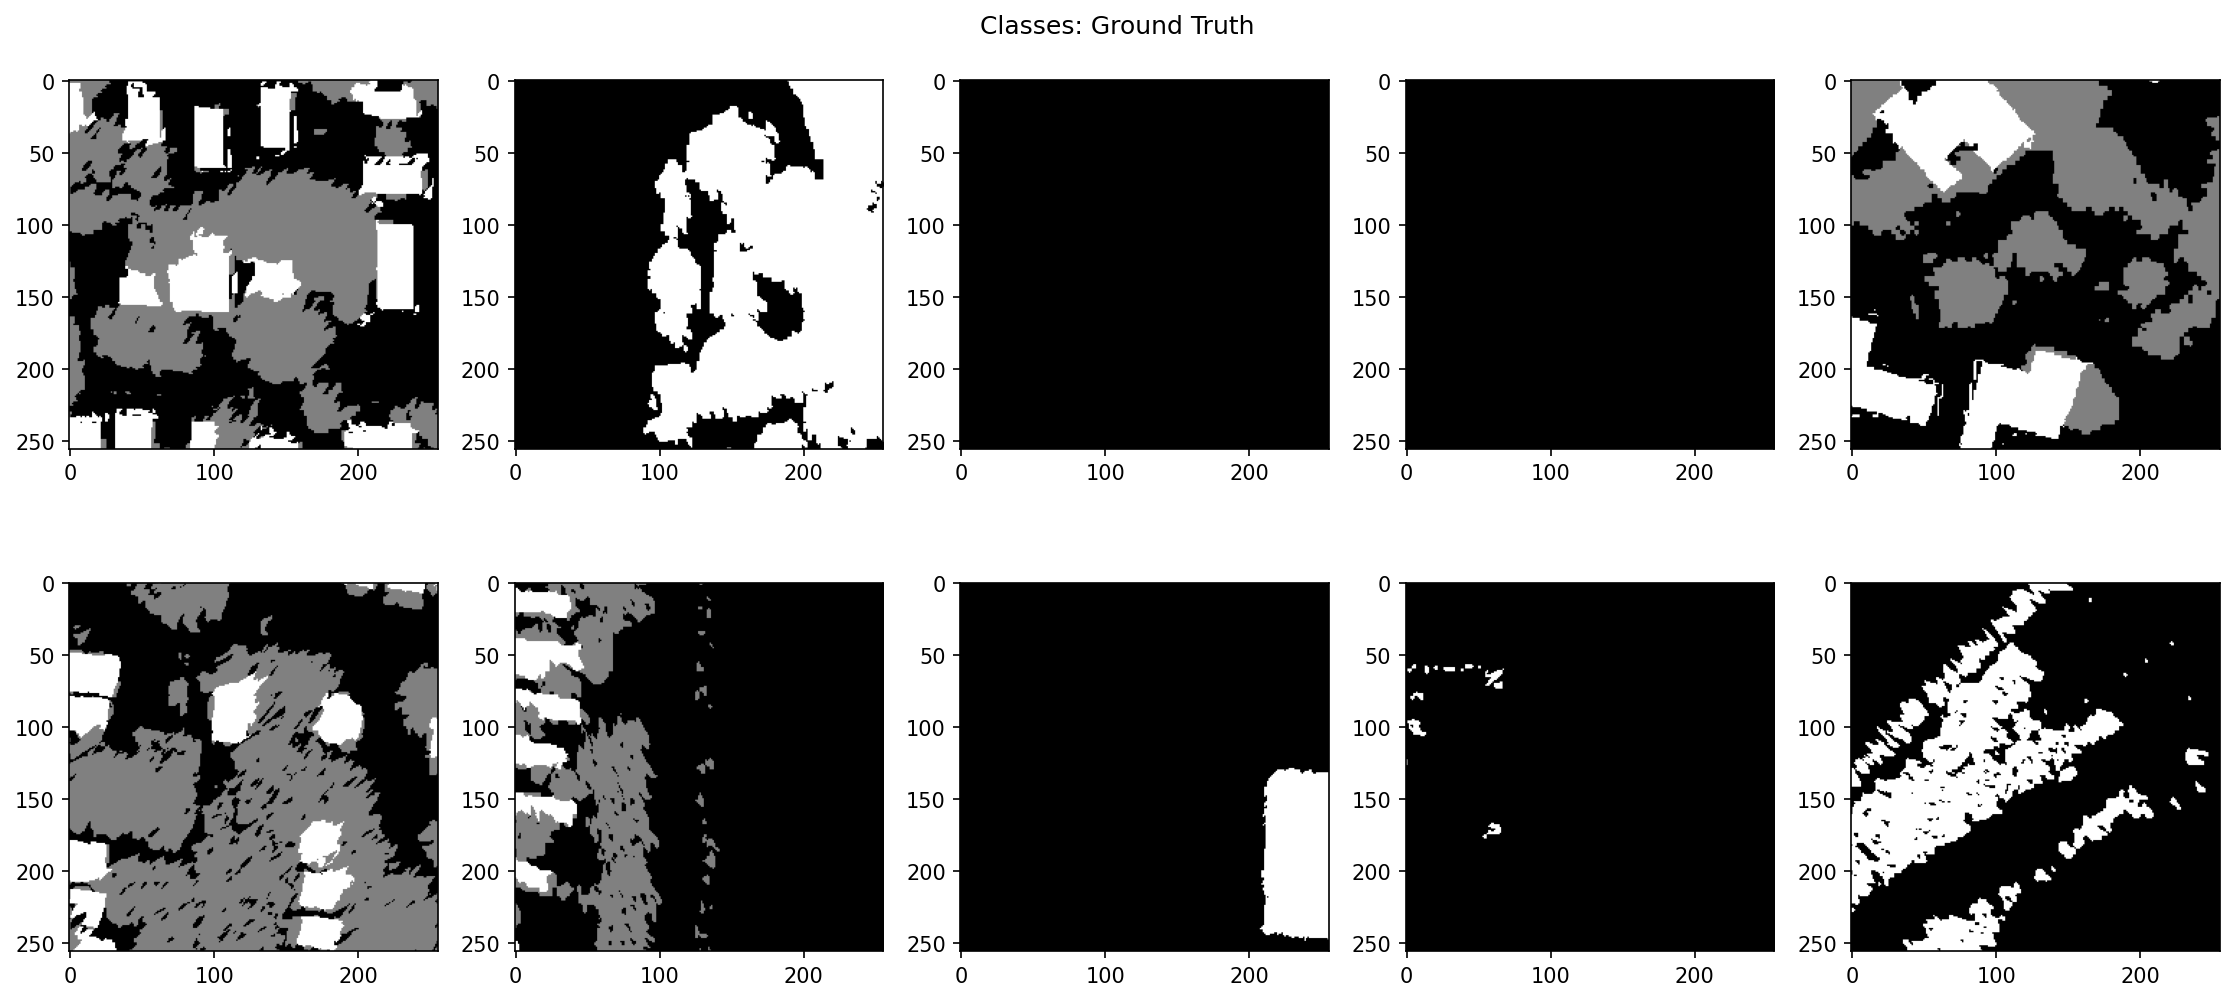

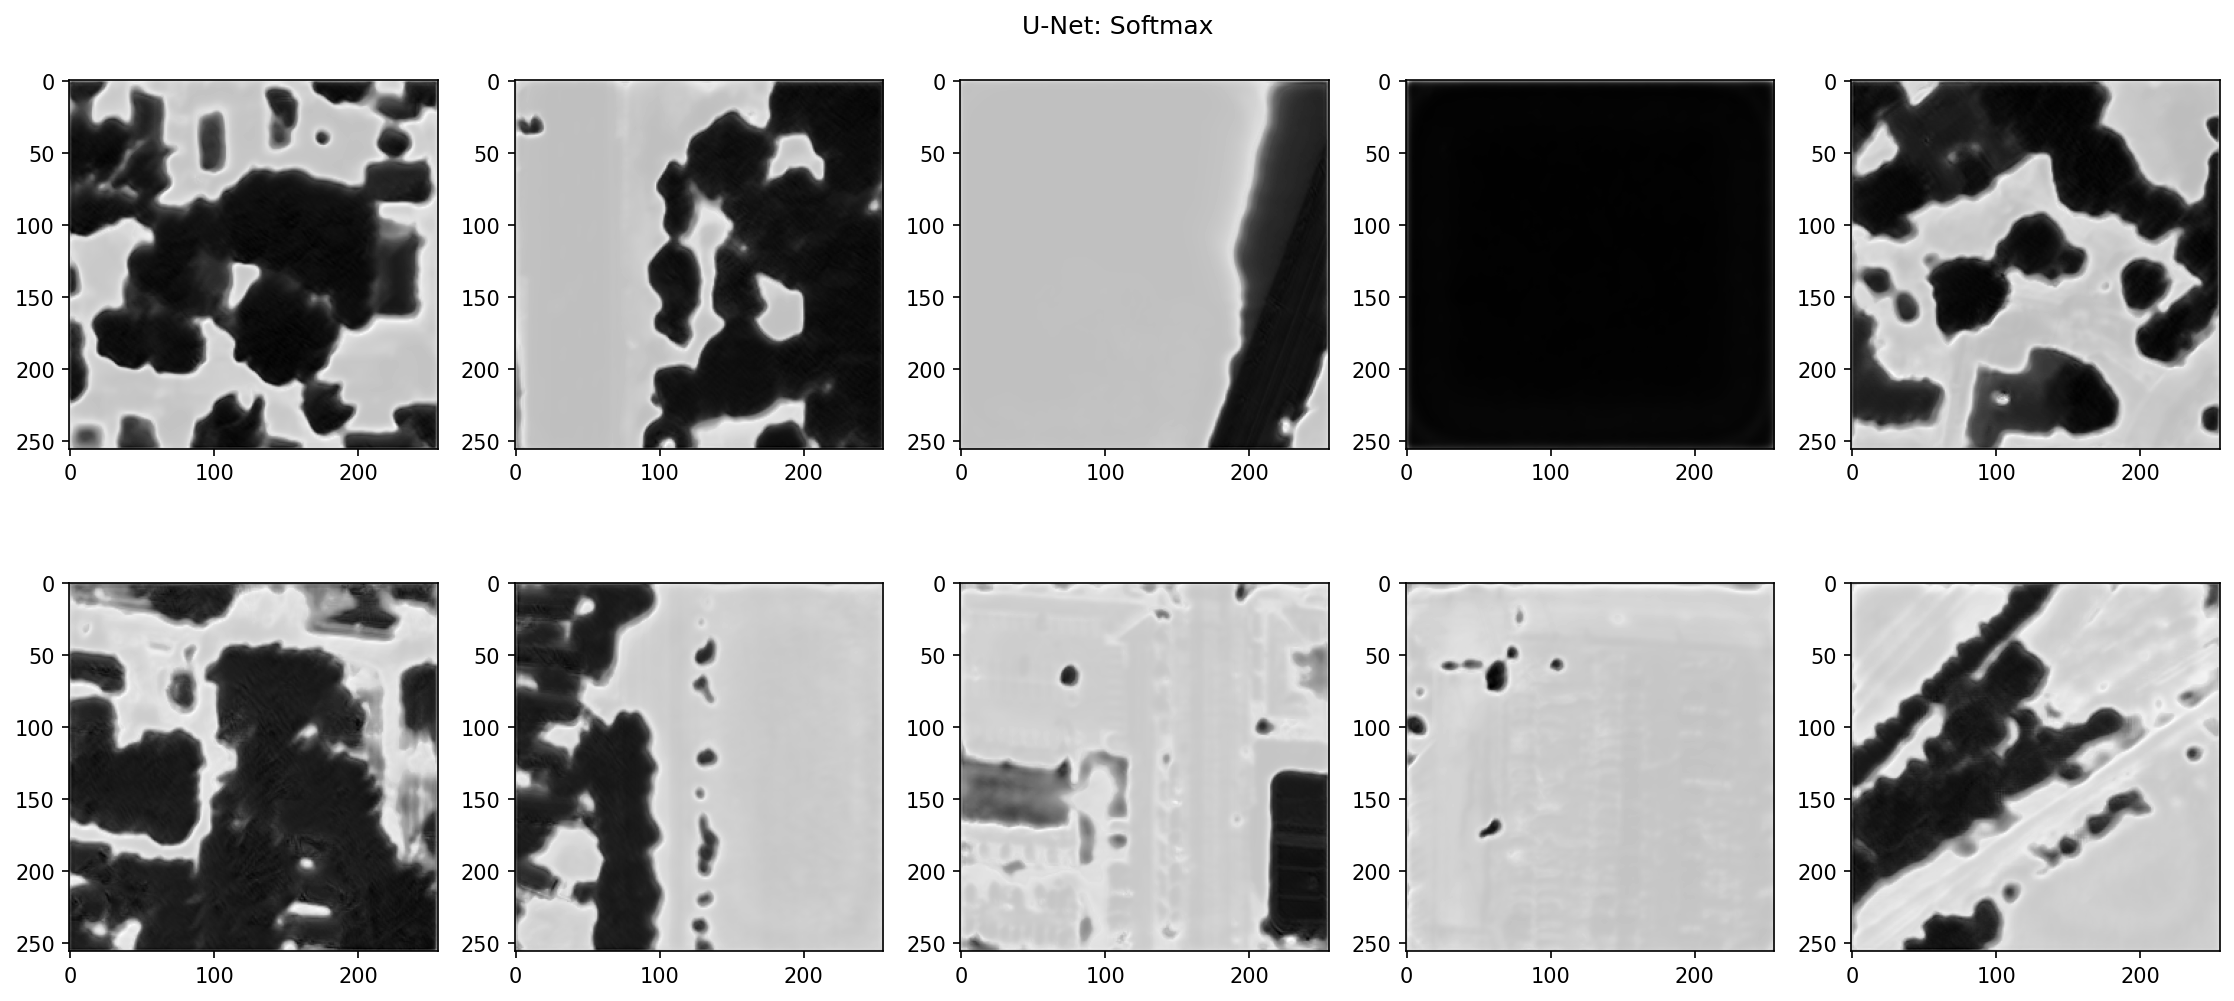

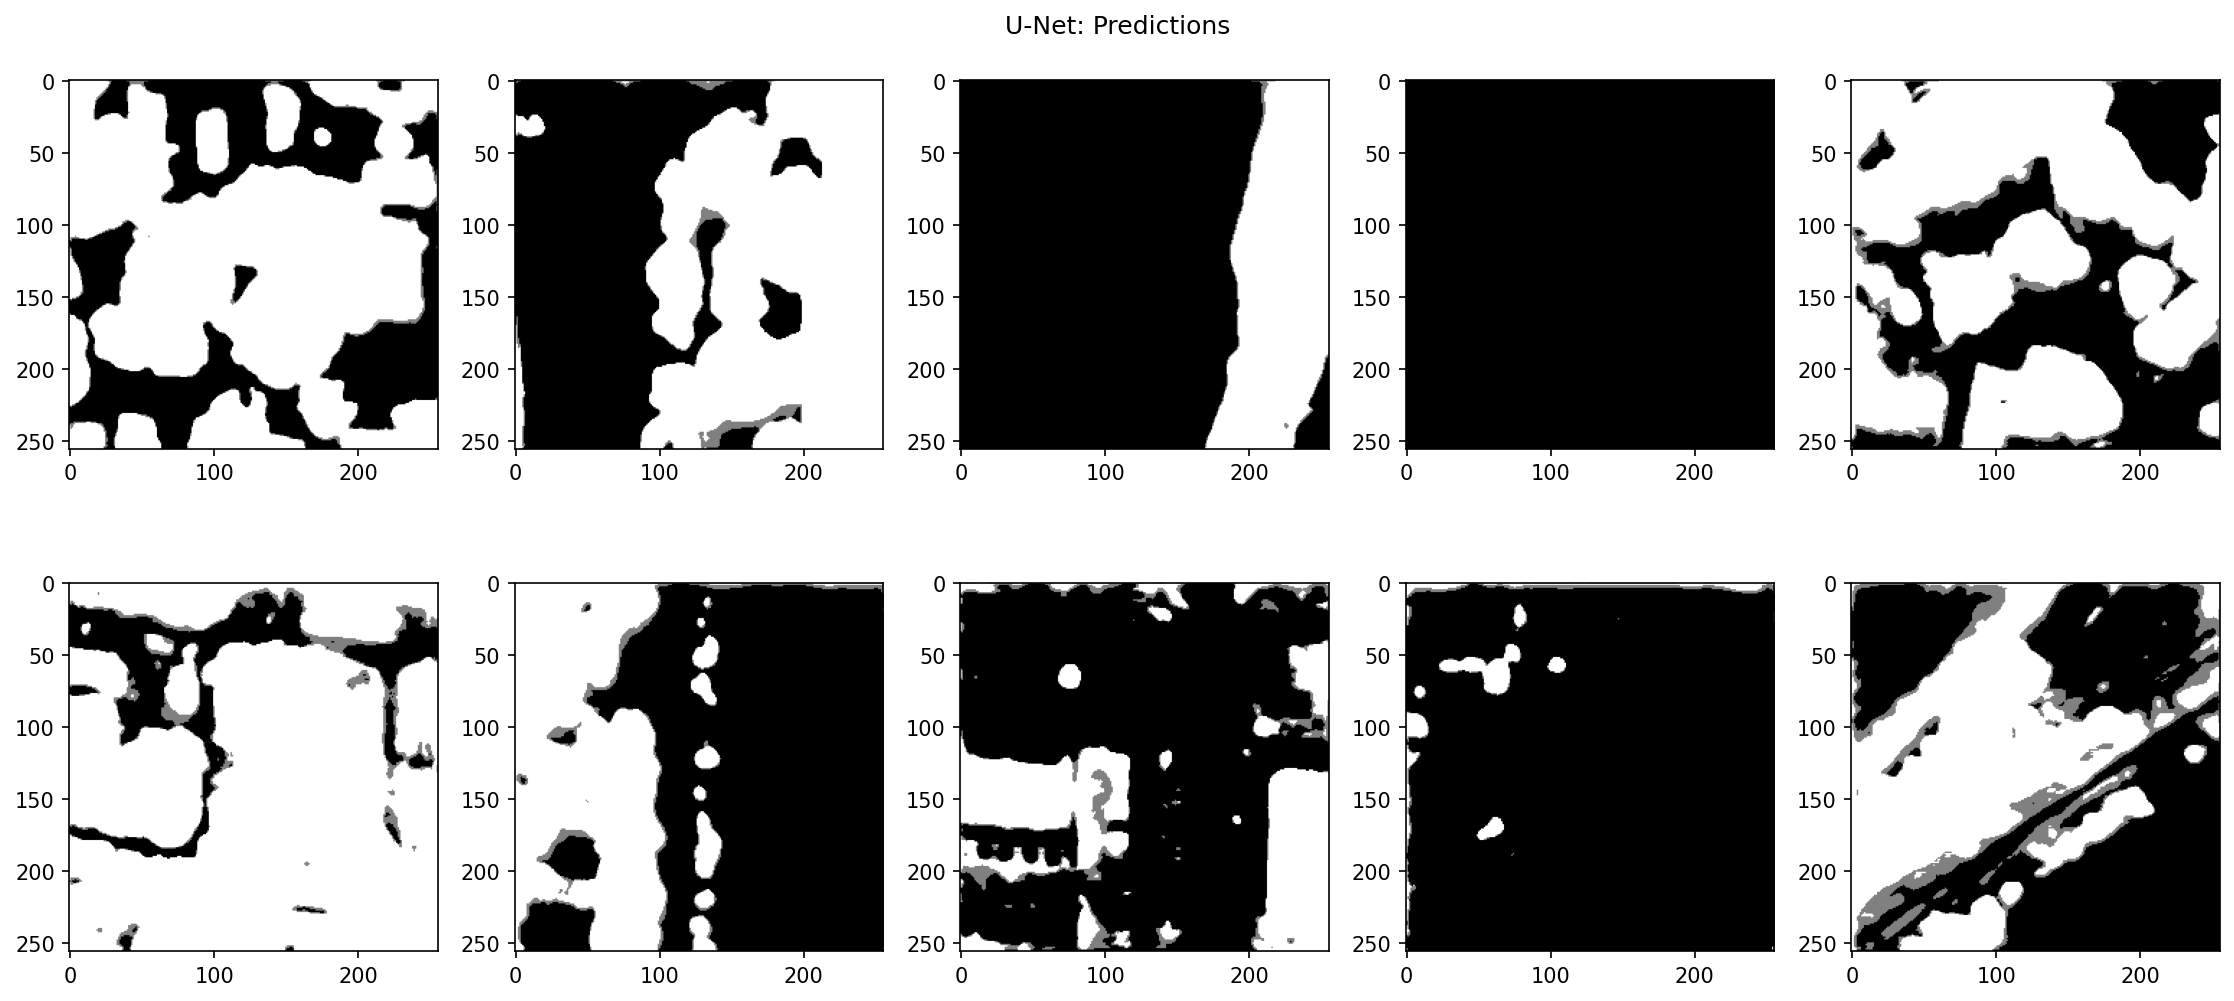

In [64]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

fig,ax = plt.subplots(nrows=2,ncols=np.ceil(len(YValid)/32).astype(int),figsize=(15,7),dpi=150)
ax = ax.reshape(-1)
i=0
for imgIdx in range(3,len(YValid),16):
    ax[i].imshow(YValid[imgIdx],cmap='gray')
    # plt.colorbar()
    i=i+1
fig.tight_layout()
fig.suptitle('Classes: Ground Truth')
plt.show()

fig,ax = plt.subplots(nrows=2,ncols=np.ceil(len(YValid)/32).astype(int),figsize=(15,7),dpi=150)
ax = ax.reshape(-1)
i=0
for imgIdx in range(3,len(YValid),16):
    ax[i].imshow(rgb2gray(predictionsSoftmax[imgIdx]),cmap='gray')
    # plt.colorbar()
    i=i+1
fig.tight_layout()
fig.suptitle('U-Net: Softmax')
plt.show()

fig,ax = plt.subplots(nrows=2,ncols=np.ceil(len(YValid)/32).astype(int),figsize=(15,7),dpi=150)
ax = ax.reshape(-1)
i=0
for imgIdx in range(3,len(YValid),16):
    ax[i].imshow(predictions[imgIdx],cmap='gray')
    # plt.colorbar()
    i=i+1
fig.tight_layout()
fig.suptitle('U-Net: Predictions')
plt.show()